## Unsupervised Learning Trading Strategy

* Download/load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize portfolio returns and compare to SP500 returns.

#### All packages needed

* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [1]:
# !pip install pandas-datareader
# !pip install pandas-ta

### 1. Download/Load SP500 stocks prices data.

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [3]:
# sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
# sp500["Symbol"] = sp500["Symbol"].str.replace('.', '-')
# symbols_list = sp500["Symbol"].unique().tolist()
# symbols_list

In [4]:
# end_date = "2023-09-27"
# start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)
# start_date, end_date

In [5]:
# df = yf.download(tickers=symbols_list,
#                 start=start_date,
#                 end=end_date)
# df

In [7]:
# df.to_pickle('df.pkl')
df = pd.read_pickle('df.pkl')

In [8]:
df = df.stack()
df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622629   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302032   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.604256  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   Volume  
Date       Ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[985955 rows x 6 columns]

In [9]:
df.columns = df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
Date       Ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622629   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302032   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.604256  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
Date       Ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[985955 rows x 6 columns]

### 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

Garman-Klass Volatility = ((ln(High) - ln(Low))^2 / 2 ) - (2ln(2) - 1)(ln(Adj Close) - ln(Open))^2

In [10]:
df['garman_klass_vol'] = (np.log(df["high"]) - np.log(df["low"]))**2/2 - (2*np.log(2)-1)*(np.log(df["adj close"]) - np.log(df["open"]))**2
df

Price               adj close       close        high         low        open  \
Date       Ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622629   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302032   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.604256  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol  
Date       Ticker                                 
2015-09-29 A         2252400.0         -0.001082  
           AAL       7478800.0         -0.000443  
           AAPL    293461600.0         -0.005833  
           ABBV     12842800.0         -0.057368  
           ABT      12287500.0         -0.010064  
...                        ...               ...  
2023-09-26 XYL       1322400.0         -0.000058  
           YUM       1500600.0         -0.000124  
           ZBH       3610500.0          0.000022  
           ZBRA       355400.0          0.000133  
           ZTS       1463200.0          0.000049  

[985955 rows x 7 columns]

In [11]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df

Price               adj close       close        high         low        open  \
Date       Ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622629   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302032   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.604256  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi  
Date       Ticker                                            
2015-09-29 A         2252400.0         -0.001082        NaN  
           AAL       7478800.0         -0.000443        NaN  
           AAPL    293461600.0         -0.005833        NaN  
           ABBV     12842800.0         -0.057368        NaN  
           ABT      12287500.0         -0.010064        NaN  
...                        ...               ...        ...  
2023-09-26 XYL       1322400.0         -0.000058  26.146731  
           YUM       1500600.0         -0.000124  36.057133  
           ZBH       3610500.0          0.000022  31.893227  
           ZBRA       355400.0          0.000133  29.494977  
           ZTS       1463200.0          0.000049  42.623457  

[985955 rows x 8 columns]

<Axes: xlabel='Date'>

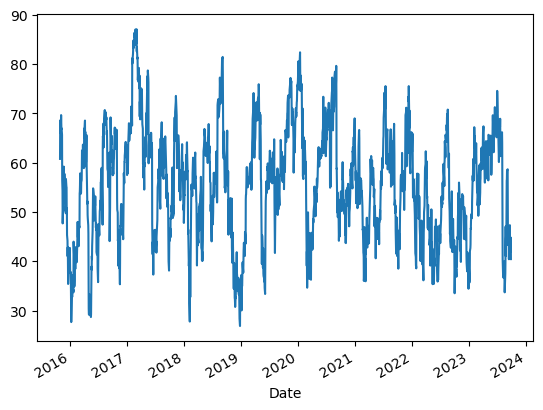

In [12]:
df.xs('AAPL', level=1)['rsi'].plot()

In [13]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])
df

Price               adj close       close        high         low        open  \
Date       Ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622629   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302032   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.604256  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005833        NaN       NaN   
           ABBV     12842800.0         -0.057368        NaN       NaN   
           ABT      12287500.0         -0.010064        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000058  26.146731  4.483137   
           YUM       1500600.0         -0.000124  36.057133  4.806770   
           ZBH       3610500.0          0.000022  31.893227  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000049  42.623457  5.153746   

Price                bb_mid   bb_high  
Date       Ticker                      
2015-09-29 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2023-09-26 XYL     4.565058  4.646979  
           YUM     4.836734  4.866698  
           ZBH     4.785551  4.825217  
           ZBRA    5.539167  5.677342  
           ZTS     5.212559  5.271371  

[985955 rows x 11 columns]

In [16]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                         low=stock_data['low'],
                         close=stock_data['close'],
                         length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

df

Price               adj close       close        high         low        open  \
Date       Ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622629   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302032   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.604256  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005833        NaN       NaN   
           ABBV     12842800.0         -0.057368        NaN       NaN   
           ABT      12287500.0         -0.010064        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000058  26.146731  4.483137   
           YUM       1500600.0         -0.000124  36.057133  4.806770   
           ZBH       3610500.0          0.000022  31.893227  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000049  42.623457  5.153746   

Price                bb_mid   bb_high       atr  
Date       Ticker                                
2015-09-29 A            NaN       NaN       NaN  
           AAL          NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
...                     ...       ...       ...  
2023-09-26 XYL     4.565058  4.646979  0.033553  
           YUM     4.836734  4.866698  0.139660  
           ZBH     4.785551  4.825217 -0.382238  
           ZBRA    5.539167  5.677342 -0.057491  
           ZTS     5.212559  5.271371  0.651510  

[985955 rows x 12 columns]

In [20]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df

Price               adj close       close        high         low        open  \
Date       Ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622629   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302032   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.604256  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005833        NaN       NaN   
           ABBV     12842800.0         -0.057368        NaN       NaN   
           ABT      12287500.0         -0.010064        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000058  26.146731  4.483137   
           YUM       1500600.0         -0.000124  36.057133  4.806770   
           ZBH       3610500.0          0.000022  31.893227  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000049  42.623457  5.153746   

Price                bb_mid   bb_high       atr      macd  
Date       Ticker                                          
2015-09-29 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2023-09-26 XYL     4.565058  4.646979  0.033553 -2.153901  
           YUM     4.836734  4.866698  0.139660 -1.365098  
           ZBH     4.785551  4.825217 -0.382238 -0.877000  
           ZBRA    5.539167  5.677342 -0.057491 -1.597348  
           ZTS     5.212559  5.271371  0.651510 -1.184942  

[985955 rows x 13 columns]

In [21]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

Price               adj close       close        high         low        open  \
Date       Ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622629   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302032   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.604256  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005833        NaN       NaN   
           ABBV     12842800.0         -0.057368        NaN       NaN   
           ABT      12287500.0         -0.010064        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000058  26.146731  4.483137   
           YUM       1500600.0         -0.000124  36.057133  4.806770   
           ZBH       3610500.0          0.000022  31.893227  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000049  42.623457  5.153746   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
Date       Ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.782210  
           AAL          NaN       NaN       NaN       NaN     279.420069  
           AAPL         NaN       NaN       NaN       NaN    7225.796151  
           ABBV         NaN       NaN       NaN       NaN     462.394152  
           ABT          NaN       NaN       NaN       NaN     409.198724  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.565058  4.646979  0.033553 -2.153901     117.033853  
           YUM     4.836734  4.866698  0.139660 -1.365098     182.479346  
           ZBH     4.785551  4.825217 -0.382238 -0.877000     402.696470  
           ZBRA    5.539167  5.677342 -0.057491 -1.597348      79.595386  
           ZTS     5.212559  5.271371  0.651510 -1.184942     256.251853  

[985955 rows x 14 columns]

### 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [22]:
df.unstack('Ticker')['dollar_volume']

Price        adj close                                                \
Ticker               A        AAL        AAPL        ABBV        ABT   
Date                                                                   
2015-09-29   31.425240  37.361618   24.622629   36.004154  33.302032   
2015-09-30   31.974754  37.027866   24.902594   37.109035  33.909058   
2015-10-01   31.425240  37.380684   24.740036   37.600098  34.364319   
2015-10-02   32.291424  36.837139   24.920652   38.070698  34.887032   
2015-10-05   32.915459  38.324741   25.010963   38.657238  34.895466   
...                ...        ...         ...         ...        ...   
2023-09-20  111.665192  13.060000  174.596573  147.895828  98.237503   
2023-09-21  108.944801  13.060000  173.044495  147.722504  96.915009   
2023-09-22  110.612785  12.900000  173.900116  147.058197  96.150894   
2023-09-25  111.138992  12.910000  175.183578  148.897141  95.484749   
2023-09-26  109.937645  12.700000  171.084549  148.184662  94.270004   

Price                                                                 ...  \
Ticker           ACGL         ACN        ADBE         ADI        ADM  ...   
Date                                                                  ...   
2015-09-29  24.416668   83.103905   79.830002   44.982410  31.690100  ...   
2015-09-30  24.490000   84.531975   82.220001   46.946495  32.022301  ...   
2015-10-01  24.463333   84.686813   83.750000   45.723091  32.030022  ...   
2015-10-02  24.780001   85.504089   83.989998   46.347286  32.771667  ...   
2015-10-05  24.993334   87.422546   85.839996   47.795376  33.714184  ...   
...               ...         ...         ...         ...        ...  ...   
2023-09-20  81.320000  311.763947  535.780029  173.060547  76.861397  ...   
2023-09-21  80.290001  307.040253  513.880005  170.858963  76.377251  ...   
2023-09-22  80.959999  311.065186  512.900024  172.470825  74.537544  ...   
2023-09-25  81.150002  311.950897  511.600006  172.421707  74.847389  ...   
2023-09-26  81.260002  305.672333  506.299988  169.384674  73.656410  ...   

Price      dollar_volume                                                    \
Ticker               DOW         UBER        CTVA         CRWD        CARR   
Date                                                                         
2015-09-29           NaN          NaN         NaN          NaN         NaN   
2015-09-30           NaN          NaN         NaN          NaN         NaN   
2015-10-01           NaN          NaN         NaN          NaN         NaN   
2015-10-02           NaN          NaN         NaN          NaN         NaN   
2015-10-05           NaN          NaN         NaN          NaN         NaN   
...                  ...          ...         ...          ...         ...   
2023-09-20    115.059001  1051.192083  210.748234   455.630587  151.730591   
2023-09-21    211.148424  1242.810177  179.119672  1103.920005  217.065943   
2023-09-22    213.107179   717.607865  162.966817   509.559431  180.821353   
2023-09-25    210.191458   412.067213  219.504695   348.097860  169.339784   
2023-09-26    165.499144   499.524977  191.532698   387.414758  376.066821   

Price                                                                    
Ticker            OTIS         ABNB         CEG        GEHC        KVUE  
Date                                                                     
2015-09-29         NaN          NaN         NaN         NaN         NaN  
2015-09-30         NaN          NaN         NaN         NaN         NaN  
2015-10-01         NaN          NaN         NaN         NaN         NaN  
2015-10-02         NaN          NaN         NaN         NaN         NaN  
2015-10-05         NaN          NaN         NaN         NaN         NaN  
...                ...          ...         ...         ...         ...  
2023-09-20  115.133239   716.133861  101.037654  116.600027  313.307666  
2023-09-21  220.522271  1130.273325  157.519195  138.582401  412.115687  
2023-